In [1]:
import networkx as nx
import dependency
import sentence_attentions

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

from itertools import cycle, islice

from tqdm import tqdm

%matplotlib inline

In [2]:
dev = False
if dev:
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev.conllu'
    no_softmax = False
else:
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest.conllu'
    no_softmax = True
    

In [3]:
maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True



dependency_rels = dependency.read_conllu_labeled(conllu_file_name)
dependency_rels = [dependency.postprocess(sent_rel) for sent_rel in dependency_rels]

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

tokens_grouped, common_tokens = dependency.group_wordpieces(tokens_loaded, conllu_file_name)

In [8]:
tokens_grouped[257]

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22]]

In [9]:
common_tokens[257]

['those',
 'who',
 'are',
 'competent',
 'among',
 'us',
 'and',
 'responsible',
 'enough',
 'to',
 'solve',
 'their',
 'own',
 'problems',
 'are',
 ',',
 'we',
 'believe',
 ',',
 'the',
 'people',
 'themselves',
 '.']

##  Plot graphs

In [10]:
def draw_graphs(layers, heads, threshold,  sentence):
    sentences = [sentence]
    attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
    #attention_gen = enumerate(attention_gen)

    viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}
    
    sentence_index = sentence
    matrices = viss[sentence_index]

    words_list = common_tokens[sentence_index]
    words = ' '.join(words_list)

    edge_labeled = {(d, h) : l for d, h, l in dependency_rels[sentence_index]}

    print(sentence_index)
    print(words)

    DG=nx.DiGraph()
    DG.add_edges_from(edge_labeled.keys())

    labels = {}
    for node in DG.nodes():
        labels[node] = words_list[node]
    posG = nx.spring_layout(DG)

    aggr_matrix = np.mean(np.array(matrices)[layers,heads,:,:], axis=0)

    AG = nx.from_numpy_matrix(aggr_matrix, parallel_edges=True, create_using=nx.DiGraph)

    elarge = [(u, v) for (u, v, d) in AG.edges(data=True) if d['weight'] > 0.2]
    weights = [AG[u][v]['weight'] *10 for u,v in elarge]
    posA = nx.spring_layout(AG)



    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))


    nx.draw_networkx_nodes(DG, posG, ax=ax1)
    nx.draw_networkx_edges(DG, posG, ax=ax1)
    nx.draw_networkx_labels(DG, posG,labels, font_size=12, ax=ax1)
    nx.draw_networkx_edge_labels(DG,posG,edge_labels= edge_labeled, font_size=8,font_color='red', ax=ax1)

    nx.draw_networkx_nodes(AG, posA, ax=ax2)
    nx.draw_networkx_edges(AG, posA,edgelist=elarge,  alpha=0.5, width=weights, ax=ax2)
    nx.draw_networkx_labels(AG, posA,labels, font_size=12, ax=ax2)


    plt.show()

In [11]:
sentences = [344]
attention_gen = sentence_attentions.generate_matrices(attentions_loaded, tokens_grouped, eos, no_softmax, maxlen,sentences)
#attention_gen = enumerate(attention_gen)

viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}

1it [00:00,  5.42it/s]


### Subjects

1it [00:00,  3.25it/s]
/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/ha/home/limisiewicz/.virtualenvs/general/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


257
those who are competent among us and responsible enough to solve their own problems are , we believe , the people themselves .


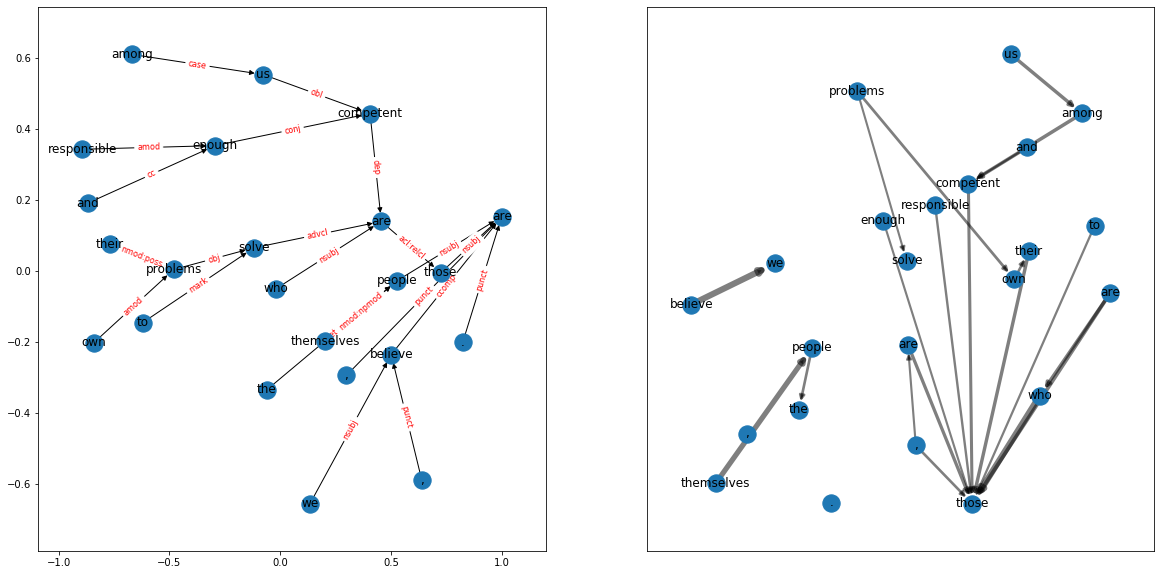

In [12]:
l = [4,7,8]
h = [10, 11, 10]
sentences = draw_graphs(l,h,0.2,257)

### Objects

1it [00:00,  4.25it/s]


445
the last speaker addressed some of the points that i would wish to make .


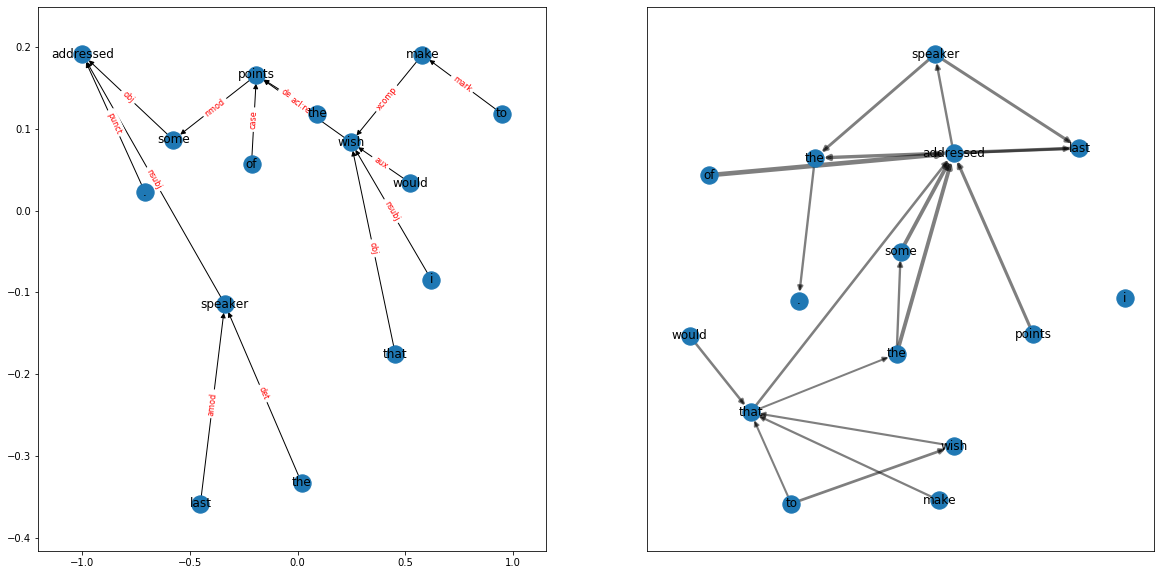

In [13]:
l = [7, 6, 3, 6, 4, 5, 3]
h = [ 9,  9, 11, 10,  6,  3,  8]
sentences = draw_graphs(l,h,0.2,445)

### Detrminers

1it [00:00,  4.53it/s]


745
there is indeed an urgent need when it comes to the damaged infrastructure .


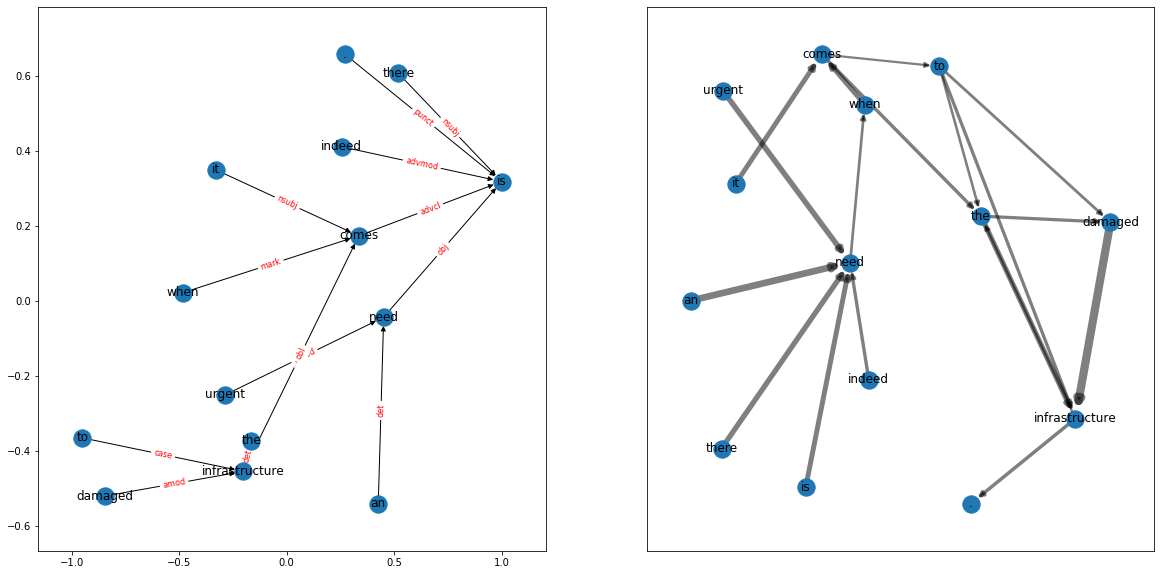

In [14]:
l = [7, 3, 4, 8]
h  = [10,  9,  5, 10]
sentences = draw_graphs(l,h,0.2,745)

### Adjective modifier

1it [00:01,  1.23s/it]


61
this area is one of the missing links in the internal market , and i very much hope that parliament and the commission will speed up one of the important directives proposed under the consumer rights directive , which aims to have a set of rules that will bring more certainty and more confidence - from the point of view of consumers and of businesses - to improve this really very poor level of cross -border trade in europe .


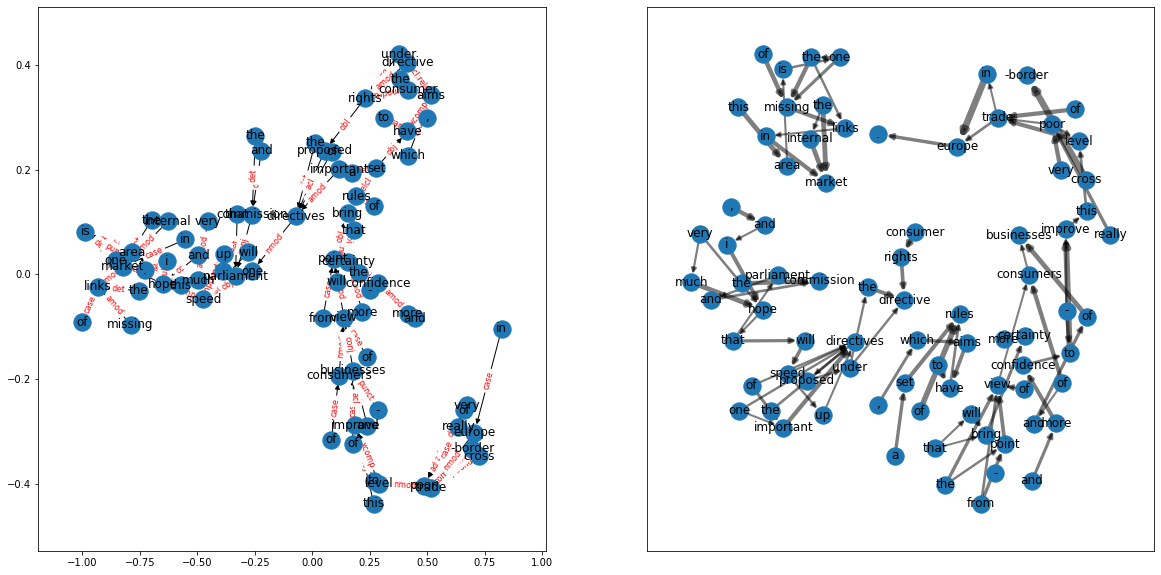

In [15]:
l = [3, 7, 5, 8, 7, 0]
h  = [ 9, 10,  7,  5,  6,  8]
sentences = draw_graphs(l,h,0.2,61)

# All

1it [00:00,  3.72it/s]


149
there are many areas in which women 's circumstances could be improved , including ensuring adequate social cover .


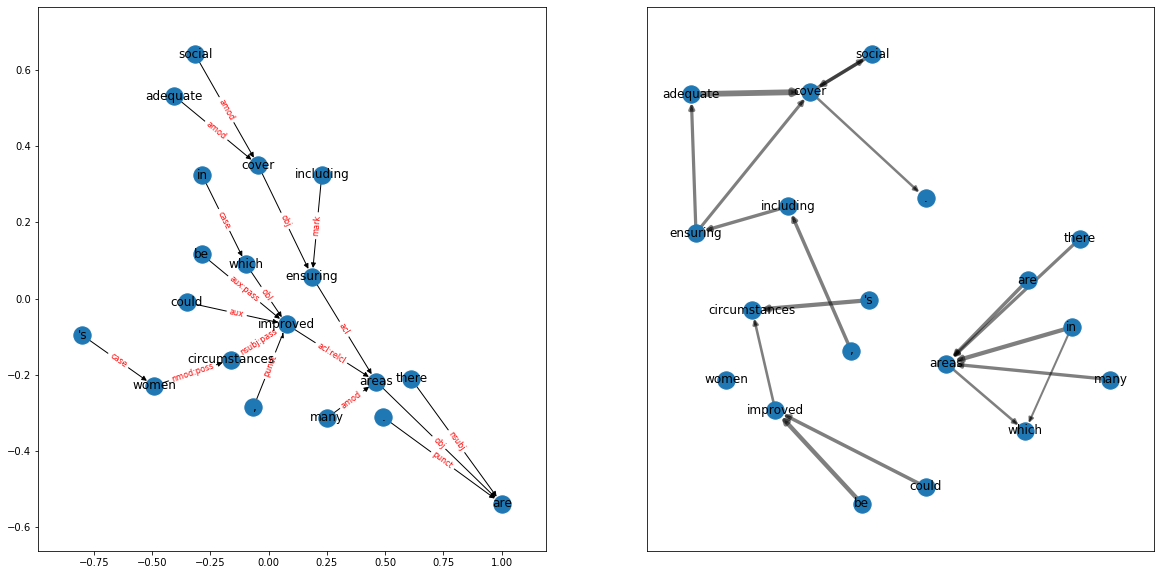

In [16]:
l = [3, 7, 6, 8, 4, 3, 0, 0]
h  = [ 9, 10,  5,  5,  5, 10,  8, 11]
sentences = draw_graphs(l,h,0.2,149)